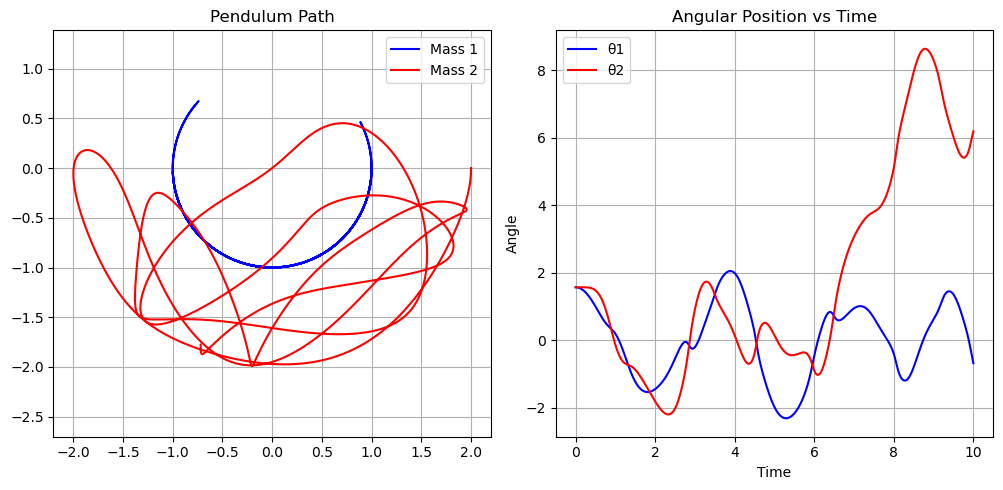

In [42]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def double_pendulum_deriv(state, t, m1, m2, L1, L2, g):
    theta1, omega1, theta2, omega2 = state
    
    # Helper terms
    c = np.cos(theta1 - theta2)
    s = np.sin(theta1 - theta2)
    
    # Denominator terms
    den = L1 * (m1 + m2 * (1 - c**2))
    
    # Equations of motion
    dtheta1 = omega1
    dtheta2 = omega2
    
    domega1 = (-g*(m1+m2)*np.sin(theta1) - m2*g*np.sin(theta1-2*theta2) 
               - 2*s*m2*(omega2**2*L2 + omega1**2*L1*c)) / (2*L1*(m1+m2-m2*c**2))
    
    domega2 = (2*s*(omega1**2*L1*(m1+m2) + g*(m1+m2)*np.cos(theta1) 
               + omega2**2*L2*m2*c)) / (2*L2*(m1+m2-m2*c**2))
    
    return [dtheta1, domega1, dtheta2, domega2]

def double_pendulum_hamiltonian(state, m1, m2, L1, L2, g):
    """
    Calculate the Hamiltonian (total energy) of the double pendulum system
    state = [theta1, omega1, theta2, omega2]
    """
    theta1, omega1, theta2, omega2 = state
    
    # Calculate velocities
    v1x = L1 * omega1 * np.cos(theta1)
    v1y = L1 * omega1 * np.sin(theta1)
    v2x = L1 * omega1 * np.cos(theta1) + L2 * omega2 * np.cos(theta2)
    v2y = L1 * omega1 * np.sin(theta1) + L2 * omega2 * np.sin(theta2)
    
    # Kinetic energy
    T1 = 0.5 * m1 * (v1x**2 + v1y**2)
    T2 = 0.5 * m2 * (v2x**2 + v2y**2)
    T = T1 + T2
    
    # Potential energy
    y1 = -L1 * np.cos(theta1)
    y2 = y1 - L2 * np.cos(theta2)
    V = m1 * g * y1 + m2 * g * y2
    
    # Total energy
    H = T + V
    return H
    

# System parameters
m1, m2 = 1.0, 1.0  # masses
L1, L2 = 1.0, 1.0  # lengths
g = 9.81  # gravity

# Initial conditions [theta1, omega1, theta2, omega2]
state0 = [np.pi/2, 0, np.pi/2, 0]

# Time points
t = np.linspace(0, 10, 1000)

# Solve ODE
solution = odeint(double_pendulum_deriv, state0, t, args=(m1, m2, L1, L2, g))

# Convert to Cartesian coordinates
x1 = L1 * np.sin(solution[:, 0])
y1 = -L1 * np.cos(solution[:, 0])
x2 = x1 + L2 * np.sin(solution[:, 2])
y2 = y1 - L2 * np.cos(solution[:, 2])

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(x1, y1, 'b-', label='Mass 1')
plt.plot(x2, y2, 'r-', label='Mass 2')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.title('Pendulum Path')

plt.subplot(122)
plt.plot(t, solution[:, 0], 'b-', label='θ1')
plt.plot(t, solution[:, 2], 'r-', label='θ2')
plt.grid(True)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Angle')
plt.title('Angular Position vs Time')

plt.tight_layout()
plt.show()

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HamiltonianNet(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        

        # either use learned T (self.T) or true T (self.true_T)
        # Kinetic energy network T(p) 
        self.Tnet = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        # Potential energy network V(q)
        self.Vnet = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
    
    def T(self, p):
        """Kinetic energy T(p)"""
        return 0.5 * p.norm(dim=-1)**2
        # return self.Tnet(p)
    
    def V(self, q):
        """Potential energy V(q)"""
        return self.Vnet(q)
    
    def hamiltonian(self, q, p):
        """Compute Hamiltonian H = T(p) + V(q)"""
        return self.T(p) + self.V(q)


    def forward(self, q, p, dt):
        """Leapfrog integration step"""        
        # Set requires_grad=True for q and p so that we can take derivatives of the Hamiltonian
        q = q.requires_grad_(True)
        p = p.requires_grad_(True)

        # Half step in momentum
        dV = torch.autograd.grad(self.V(q).sum(), q, create_graph=True)[0]
        p_half = p - 0.5 * dt * dV

        # Full step in position
        dT = torch.autograd.grad(self.T(p_half).sum(), p_half, create_graph=True)[0]
        q_new = q + dt * dT
        
        # Half step in momentum
        dV = torch.autograd.grad(self.V(q_new).sum(), q_new, create_graph=True)[0]
        p_new = p_half - 0.5 * dt * dV
        
        return [q_new, p_new]

# # Example usage
# model = HamiltonianNet()
# data = 
# state = torch.randn(32, 2)  # batch of [q, p] pairs
# dt = 0.1
# # next_state = model(state, dt)

# Generate a solution to the double pendulum ODE for training data
# state0 = torch.tensor(state0, dtype=torch.float32).unsqueeze(0)
# t = torch.tensor(t, dtype=torch.float32)
# solution = odeint(double_pendulum_deriv, state0, t, args=(m1, m2, L1, L2, g))
# solution = torch.tensor(solution, dtype=torch.float32)

# Time points
t = np.linspace(0, 2.0, 1000)
dt = t[1] - t[0]


model = HamiltonianNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

step = 0
# [qnew,pnew] = model(qsol[step,:], psol[step,:], dt)

# Generate loss function comparison predicted timestep to actual timestep
for epoch in range(100000):
    # generate random angle for initial condition
    state0 = [np.random.uniform(-0.25*np.pi, 0.25*np.pi), 0, np.random.uniform(-0.25*np.pi, 0.25*np.pi), 0]
    # Solve ODE
    solution = odeint(double_pendulum_deriv, state0, t, args=(m1, m2, L1, L2, g))
    # Convert to torch and pull out q and p
    solution = torch.tensor(solution, dtype=torch.float32)
    qsol = solution[:, [0,2]]# [theta1, theta2]
    psol = solution[:, [1,3]] # [omega1, omega2]
    optimizer.zero_grad()

    loss = 0
    for step in range(1, len(t)):
        qold = qsol[step-1,:]
        pold = psol[step-1,:]
        qnew = qsol[step,:]
        pnew = psol[step,:]
        qpred, ppred = model(qold, pold, dt)
        loss += torch.norm(qnew - qpred) + torch.norm(pnew - ppred)
    loss.backward()
    optimizer.step()
        
    if epoch%50==0:
        print(f'epoch {epoch}: Loss = {loss.item()}, H = {model.hamiltonian(qnew, pnew).item()}, Htrue = {double_pendulum_hamiltonian([qnew[0], pnew[0], qnew[1], pnew[1]], m1, m2, L1, L2, g)}')


epoch 0: Loss = 18.1336727142334, H = 0.20034384727478027, Htrue = -26.866662979125977
epoch 50: Loss = 4.406376361846924, H = -5.897849082946777, Htrue = -27.11646842956543
epoch 100: Loss = 2.338162660598755, H = -8.024850845336914, Htrue = -29.05016326904297
epoch 150: Loss = 5.210975646972656, H = -7.924063682556152, Htrue = -24.90239715576172
epoch 200: Loss = 2.830317974090576, H = -11.118773460388184, Htrue = -28.040800094604492
epoch 250: Loss = 4.906708240509033, H = -8.10732364654541, Htrue = -28.158191680908203
epoch 300: Loss = 9.725189208984375, H = -0.398801326751709, Htrue = -22.212814331054688
epoch 350: Loss = 3.8667309284210205, H = -9.593422889709473, Htrue = -27.118621826171875
epoch 400: Loss = 5.123566150665283, H = -6.500417709350586, Htrue = -27.020532608032227
epoch 450: Loss = 2.715120792388916, H = -9.575870513916016, Htrue = -24.320545196533203
epoch 500: Loss = 4.947038173675537, H = -8.913623809814453, Htrue = -23.459611892700195
epoch 550: Loss = 2.953196

KeyboardInterrupt: 

In [89]:
import os
import torch
from pathlib import Path

def save_checkpoint(model, optimizer, epoch, checkpoint_dir='checkpoints'):
    Path(checkpoint_dir).mkdir(exist_ok=True)
    
    checkpoint = {
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch
    }
    
    path = os.path.join(checkpoint_dir, f'hnn_checkpoint_epoch_{epoch}.pt')
    torch.save(checkpoint, path)

def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    return checkpoint['epoch']


save_checkpoint(model, optimizer, epoch)

# Load checkpoint example
# start_epoch, losses = load_checkpoint(model, optimizer, 'checkpoints/hnn_checkpoint_epoch_50.pt')

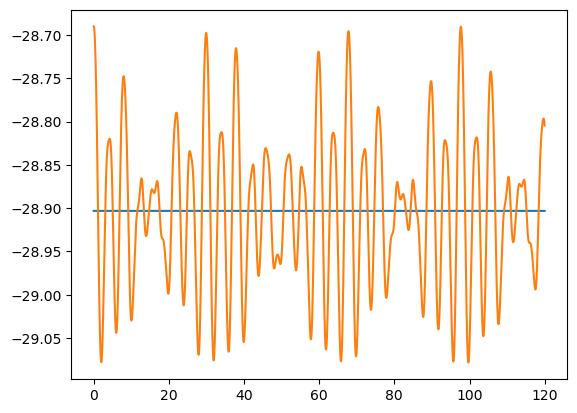

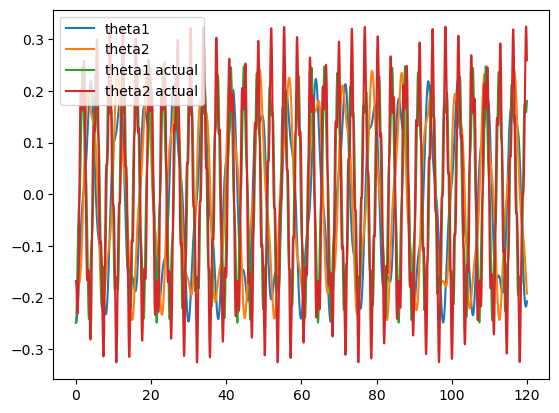

In [92]:
# generate a random initial condition and compare the predicted trajectory to the actual trajectory

t = np.linspace(0, 2.0*60, 400*60)
state0 = [np.random.uniform(-0.25*np.pi, 0.25*np.pi), 0, np.random.uniform(-0.25*np.pi, 0.25*np.pi), 0]
# Solve ODE
solution = odeint(double_pendulum_deriv, state0, t, args=(m1, m2, L1, L2, g))
# Convert to torch and pull out q and p
solution = torch.tensor(solution, dtype=torch.float32)
qsol = solution[:, [0,2]]# [theta1, theta2]
psol = solution[:, [1,3]]# [omega1, omega2]
for step in range(1, len(t)):
    qold = qsol[step-1,:]
    pold = psol[step-1,:]
    qnew = qsol[step,:]
    pnew = psol[step,:]
    qpred, ppred = model(qold, pold, dt)
    qsol[step,:] = qpred
    psol[step,:] = ppred

#plot hamiltonian
H = []
for step in range(len(t)):
    q = qsol[step,:]
    p = psol[step,:]
    H.append(model.hamiltonian(q, p).item())
H = np.array(H)
plt.figure()

#overlay plot with true hamiltonian
Htrue = []
for step in range(len(t)):
    q = qsol[step,:].detach().numpy()
    p = psol[step,:].detach().numpy()
    Htrue.append(double_pendulum_hamiltonian([q[0], p[0], q[1], p[1]], m1, m2, L1, L2, g))
Htrue = np.array(Htrue)
plt.plot(t,H + (Htrue - H).mean())
plt.plot(t,Htrue)
# plt.plot(t,H)

# convert to numpy and plot
qsol = qsol.detach().numpy()
psol = psol.detach().numpy()

plt.figure()
plt.plot(t,qsol[:,0], label='theta1')
plt.plot(t,qsol[:,1], label='theta2')
plt.plot(t,solution[:,0], label='theta1 actual')
plt.plot(t,solution[:,2], label='theta2 actual')
plt.legend()


    #


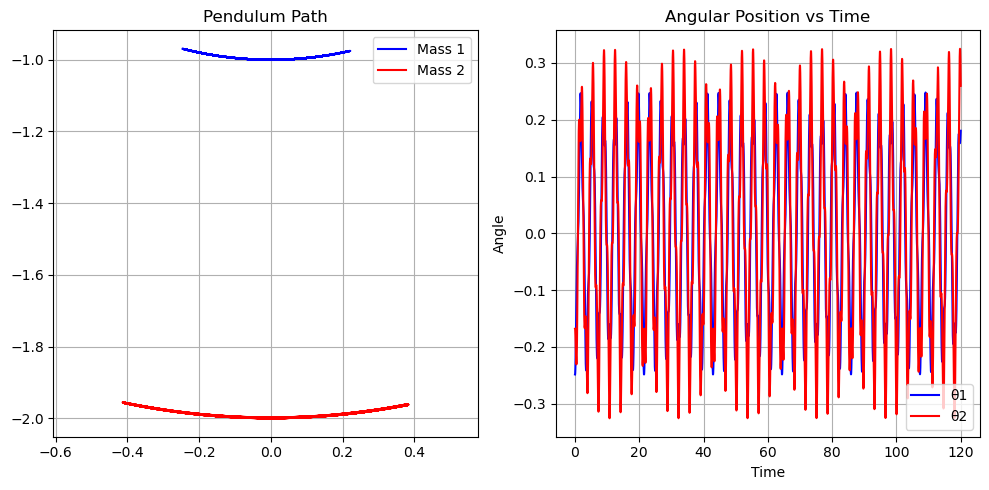

In [93]:

# Convert learned solution to Cartesian coordinates
x1 = L1 * np.sin(qsol[:,0])
y1 = -L1 * np.cos(qsol[:,0])
x2 = x1 + L2 * np.sin(qsol[:,1])
y2 = y1 - L2 * np.cos(qsol[:,1])

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(x1, y1, 'b-', label='Mass 1')
plt.plot(x2, y2, 'r-', label='Mass 2')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.title('Pendulum Path')

plt.subplot(122)
plt.plot(t, solution[:, 0], 'b-', label='θ1')
plt.plot(t, solution[:, 2], 'r-', label='θ2')
plt.grid(True)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Angle')
plt.title('Angular Position vs Time')

plt.tight_layout()
plt.show()